In [1]:
import torch
import torch.nn as nn

from torchvision import datasets, models

import matplotlib.pyplot as plt


from defenses.fine_pruning.FinePruning import fp
from trainModel import evaluate

from data_loader import get_test_loader

2024-05-16 01:14:34.304797: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 01:14:34.365179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 01:14:35.252542: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
class Opt:
    def __init__(self):

        self.dataset = 'ImageNet'
        self.cam_maps_address = './data/cam_maps.csv'
        self.trigger_type = 'camouflageTriggerCircle'
        self.target_type = 'all2one'

        self.target_label = 2

        self.batch_size = 64

        self.trig_w = 3
        self.trig_h = 3
        self.input_height = 224
        self.input_width = 224


In [14]:
opt = Opt()

In [15]:
test_data_clean_loader, test_data_bad_loader = get_test_loader(opt)

==> Preparing test data..
Generating testbad Imgs


100%|██████████| 500/500 [00:02<00:00, 189.72it/s]


Injecting Over: 0Bad Imgs, 500Clean Imgs
Generating testbad Imgs


100%|██████████| 500/500 [00:05<00:00, 86.43it/s] 

Injecting Over: 450Bad Imgs, 50Clean Imgs


In [17]:
train_model = torch.load('./saved_models/resnet18-whole_model-imagenet10.pth')

loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device("cuda")
train_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
from classifier_models import ResNet18

netCC = ResNet18(num_classes = 10).to(device)

In [20]:
netCC.conv1 = train_model.conv1
netCC.bn1 = train_model.bn1

netCC.layer1[0].conv1 = train_model.layer1[0].conv1
netCC.layer1[0].bn1 = train_model.layer1[0].bn1
netCC.layer1[0].conv2 = train_model.layer1[0].conv2
netCC.layer1[0].bn2 = train_model.layer1[0].bn2
netCC.layer1[1].conv1 = train_model.layer1[1].conv1
netCC.layer1[1].bn1 = train_model.layer1[1].bn1
netCC.layer1[1].conv2 = train_model.layer1[1].conv2
netCC.layer1[1].bn2 = train_model.layer1[1].bn2

netCC.layer2[0].conv1 = train_model.layer2[0].conv1
netCC.layer2[0].bn1 = train_model.layer2[0].bn1
netCC.layer2[0].conv2 = train_model.layer2[0].conv2
netCC.layer2[0].bn2 = train_model.layer2[0].bn2
netCC.layer2[0].shortcut = train_model.layer2[0].downsample
netCC.layer2[1].conv1 = train_model.layer2[1].conv1
netCC.layer2[1].bn1 = train_model.layer2[1].bn1
netCC.layer2[1].conv2 = train_model.layer2[1].conv2
netCC.layer2[1].bn2 = train_model.layer2[1].bn2

netCC.layer3[0].conv1 = train_model.layer3[0].conv1
netCC.layer3[0].bn1 = train_model.layer3[0].bn1
netCC.layer3[0].conv2 = train_model.layer3[0].conv2
netCC.layer3[0].bn2 = train_model.layer3[0].bn2
netCC.layer3[0].shortcut = train_model.layer3[0].downsample
netCC.layer3[1].conv1 = train_model.layer3[1].conv1
netCC.layer3[1].bn1 = train_model.layer3[1].bn1
netCC.layer3[1].conv2 = train_model.layer3[1].conv2
netCC.layer3[1].bn2 = train_model.layer3[1].bn2

netCC.layer4[0].conv1 = train_model.layer4[0].conv1
netCC.layer4[0].bn1 = train_model.layer4[0].bn1
netCC.layer4[0].conv2 = train_model.layer4[0].conv2
netCC.layer4[0].bn2 = train_model.layer4[0].bn2
netCC.layer4[0].shortcut = train_model.layer4[0].downsample
netCC.layer4[1].conv1 = train_model.layer4[1].conv1
netCC.layer4[1].bn1 = train_model.layer4[1].bn1
netCC.layer4[1].conv2 = train_model.layer4[1].conv2
netCC.layer4[1].bn2 = train_model.layer4[1].bn2

netCC.linear = train_model.fc
netCC = netCC.to(device)

In [11]:
fp(netCC, test_data_clean_loader, test_data_bad_loader, loss_fn)

Forwarding all the validation dataset:
 [========================================================>........]           7/8 .]           8/8 
Pruned 0 filters
Pruned 1 filters
Pruned 2 filters
Pruned 3 filters
Pruned 4 filters
Pruned 5 filters
Pruned 6 filters
Pruned 7 filters
Pruned 8 filters
Pruned 9 filters
Pruned 10 filters
Pruned 11 filters
Pruned 12 filters
Pruned 13 filters
Pruned 14 filters
Pruned 15 filters
Pruned 16 filters
Pruned 17 filters
Pruned 18 filters
Pruned 19 filters
Pruned 20 filters
Pruned 21 filters
Pruned 22 filters
Pruned 23 filters
Pruned 24 filters
Pruned 25 filters
Pruned 26 filters
Pruned 27 filters
Pruned 28 filters
Pruned 29 filters
Pruned 30 filters
Pruned 31 filters
Pruned 32 filters
Pruned 33 filters
Pruned 34 filters
Pruned 35 filters
Pruned 36 filters
Pruned 37 filters
Pruned 38 filters
Pruned 39 filters
Pruned 40 filters
Pruned 41 filters
Pruned 42 filters
Pruned 43 filters
Pruned 44 filters
Pruned 45 filters
Pruned 46 filters
Pruned 47 filters
Pruned

In [21]:
import csv


with open('./logs/fine_pruning/imagenet10-fine_pruning-results.txt', 'r') as txtfile, open('./logs/fine_pruning/imagenet10-fine_pruning-results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['pruned_neurals', 'ACC', 'ASR'])

    row_data = []
    
    for i, line in enumerate(txtfile, start=0):
        
        data = list(map(float, line.strip().split()))
        writer.writerow(data)


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# pruning_ans_columns = ['pruned_neurals', 'ACC', 'ASR']
pruning_ans = pd.read_csv('./logs/fine_pruning/imagenet10-fine_pruning-results.csv')

In [23]:
pruning_ans

,pruned_neurals,ACC,ASR
0,0.0,0.884,0.933
1,1.0,0.884,0.933
2,2.0,0.884,0.933
3,3.0,0.884,0.933
4,4.0,0.884,0.933
...,...,...,...
507,507.0,0.388,0.000
508,508.0,0.365,0.000
509,509.0,0.313,0.000
510,510.0,0.255,0.000


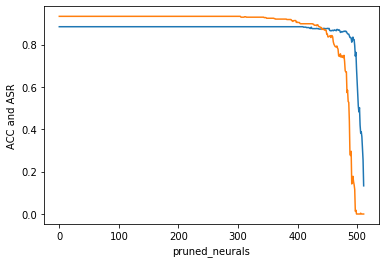

<Figure size 432x288 with 0 Axes>

In [24]:
y_1_coords = pruning_ans['ACC'].values
y_2_coords = pruning_ans['ASR'].values

plt.plot(y_1_coords, label='ACC')
plt.plot(y_2_coords, label='ASR')


plt.xlabel('pruned_neurals')
plt.ylabel('ACC and ASR')

plt.show()

plt.savefig('./logs/fine_pruning/imagenet10-fine_pruning-results.png')
